# Markov Chains


Начнем с небольшого упражнения по Марковским цепям. Пусть мы проводим ежедневные наблюдения за погодой и погода бывает одной из трех типов: солнечной, облачной или дождливой. Опишем все возможные состояния:

In [1]:
state_wheather = ("sunny", "cloudy", "rainy")

Пусть статистика многодневных наблюдений показывает, что вероятности перемены (или сохранения) состояния погоды опиcываются следующей мaтрицей переходных вероятностей:

In [2]:
import numpy as np

transition_matrix = np.array(((0.6, 0.3, 0.1),
                              (0.3, 0.4, 0.3),
                              (0.2, 0.3, 0.5)))

**Задание 1.** Выберите произвольное начальное состояние ("sunny", "cloudy" или "rainy") и смоделируйте 20000 последующих состояний в цепи Маркова с введенной выше матрицей переходов. Результат моделирования (массив размера 20000) запишите в переменную `states`.

In [3]:
# 0 = sunny, 1 = cloudy, 2 = rainy
randomes = np.random.rand(20000)
#выбираем sunny как стартовую погоду:
states = np.zeros(20000)
for i in range(1, 20000):
  previous_weather = int(states[i-1]) #тут инт, потому что в states нули с точкой плавающей и np ругается на это
  if randomes[i]<=transition_matrix[previous_weather, 0]:
    states[i] = 0
    continue
  elif randomes[i]<=(transition_matrix[previous_weather, 0] + transition_matrix[previous_weather,1]):
    states[i] = 1
    continue
  else:
    states[i] = 2
#теперь 1 =sunny, 2 = cloudy, 3 = rainy, это сделал чтобы применять np.count_nonzero
states+=1

**Задание 2.** На основе массива `states` рассчитайте, как меняется частота встречаемости каждого из типов погоды в массиве `states[:n]` для `n`, возрастающих от 1 до 20000. На одном рисунке покажите 3 графика: по оси х откладывайте `n`, по у - частоту для каждого из трех типов погоды. Должна получиться примерно следующая картинка:
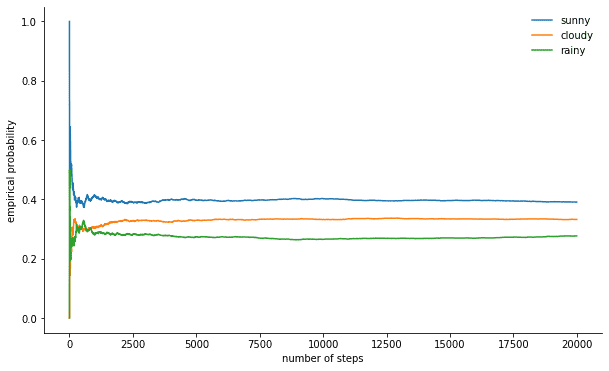

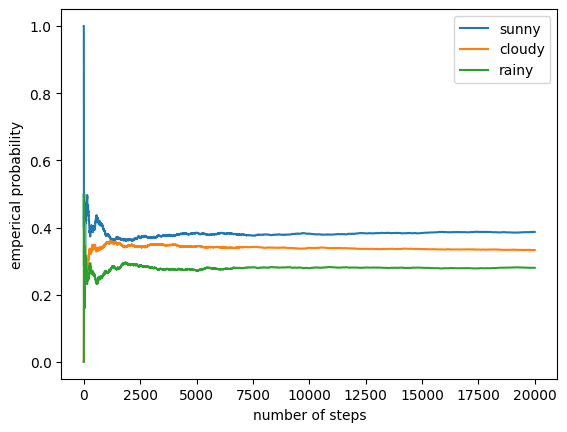

In [4]:
import matplotlib.pyplot as plt
x = [n for n in range(1,20000)]
y_sunny = [np.count_nonzero(states[:n]==1)/n for n in x]
y_cloudy = [np.count_nonzero(states[:n]==2)/n for n in x]
y_rainy = [np.count_nonzero(states[:n]==3)/n for n in x]
plt.plot(x, y_sunny, label = "sunny")
plt.plot(x, y_cloudy, label = "cloudy")
plt.plot(x, y_rainy, label = "rainy")
plt.xlabel("number of steps")
plt.ylabel("emperical probability")
plt.legend()
plt.show()

**Задание 3.** Как следует из картинки, частоты сходятся к некоторым стационарным значениям. Убедитесь, что эти значения совпадают с решением уравнения на стационарную плотность πP=π, где P - это матрица переходных вероятностей, а вектор π - искомая стационарная плотность. Дополнительно убедитесь, это этот же вектор возникает в строках матрицы P, при возведении ее во все большие степени.

[0.38888889 0.33333333 0.27777778]


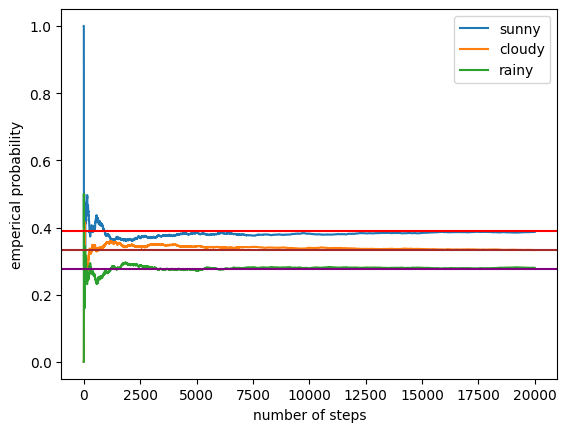

In [5]:
k = 1 #степень матрицы
temp_matrix = np.ones(9).reshape((3,3))
vector_zero_zero_one = np.array([0,0,1])
changed_matrix = np.linalg.matrix_power(transition_matrix, k)
transition_matrix_changed = changed_matrix.transpose() - np.diag(np.diag(temp_matrix))

transition_matrix_changed[2, 0] = 1
transition_matrix_changed[2, 1] = 1
transition_matrix_changed[2, 2] = 1

result = np.linalg.solve(transition_matrix_changed, vector_zero_zero_one)
print(result)
#проверка того, что вектор остается тем же для любой степени матрицы
for i in range(1, 20000):
  temp_matrix = np.ones(9).reshape((3,3))
  vector_zero_zero_one = np.array([0,0,1])
  changed_matrix = np.linalg.matrix_power(transition_matrix, i)
  transition_matrix_changed = changed_matrix.transpose() - np.diag(np.diag(temp_matrix))

  transition_matrix_changed[2, 0] = 1
  transition_matrix_changed[2, 1] = 1
  transition_matrix_changed[2, 2] = 1

  result_new = np.linalg.solve(transition_matrix_changed, vector_zero_zero_one)
  if (abs(result_new[0] - result[0]) >1e-8 or abs(result_new[1] - result[1]) >1e-8  or abs(result_new[2] - result[2]) >1e-8):
    print("We have problems!!!")
#закончили проверку
x = [n for n in range(1,20000)]
#для того чтобы показать что предельные значения совпадают с полученными, рисую просто горизонтальные линии
y_sunny = [np.count_nonzero(states[:n]==1)/n for n in x]
y_cloudy = [np.count_nonzero(states[:n]==2)/n for n in x]
y_rainy = [np.count_nonzero(states[:n]==3)/n for n in x]
plt.plot(x, y_sunny, label = "sunny")
plt.plot(x, y_cloudy, label = "cloudy")
plt.plot(x, y_rainy, label = "rainy")
plt.axhline(result[0], color = "red")
plt.axhline(result[1], color = "brown")
plt.axhline(result[2], color = "purple")
plt.xlabel("number of steps")
plt.ylabel("emperical probability")
plt.legend()
plt.show()

Приведенный выше пример показывает, что в некоторых Марковских цепях со временем устанавливается стационарное распределение. Такие цепи называются **эргодическими**. Для эргодичности достаточно, чтобы все элементы матрицы Р были строго положительны (об этом говорит эргодическая теорема). Дальше мы  воспользуемся эргодическим свойством для моделирования случайных величин.

## MCMC (Markov Chain Monte Carlo)

Рассмотрим разачу: кандидат в губернаторы объезжает города свого края с целью агитации. Каждый день для выбора следующего города он случайным образом намечает один из городов, соседних к текущему. Если число жителей в намеченном городе больше, чем в текущем, кандидат перемещается в намеченный город. В противном случае кандидат перемещается в намеченный город с вероятностью $p$, равной отношению числа жителей этого города к числу жителей текущего, и остается в текущем еще на один день с вероятностью $1-p$. Проведя достаточно долгую агитационную кампанию выясняется, что доля времени, проведенная в каждом городе, пропорциональна числу жителей этого города. Тем самым, **процесс перемещения по городам можно рассматривать как процесс генерации случайных величин** (номер города) из распределения, которое задается числом жителей в городах. Посмотрим, как это работает:

Задаем популяцию 15 городов случайными числами от 10 до 100:

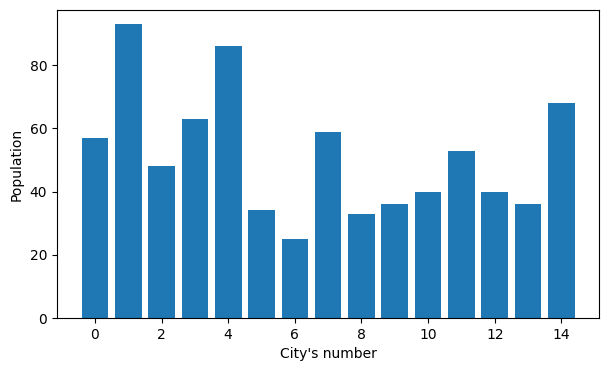

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)
cities = np.random.randint(10, 100, 15)

plt.figure(figsize=(7, 4))
plt.bar(np.arange(len(cities)), cities)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

На гистограмму выше нужно смотреть как на распределение, из которого мы хотим научиться моделировать случайные величины.

Задаем функцию, которая определяет номер следующего города, куда отправляется кандитат (возможно, остается в текущем городе). Для простоты будем перемещаться только в города с номерами на 1 больше или меньше, чем текущий:

In [7]:
def step(current, cities):
    direction = np.random.choice([-1, 1])
    target = (current + direction) % len(cities)
    ratio = cities[target] / cities[current]
    return target if np.random.rand() < ratio else current

Моделируем перемещения кандитата за период 10000 дней:

In [8]:
walk = []
current = 1 # стартуем из города с номером 1
for i in range(10000):
    current = step(current, cities)
    walk.append(current)

Рисуем гистограмму распределения доли времени, проведенного в каждом городе:

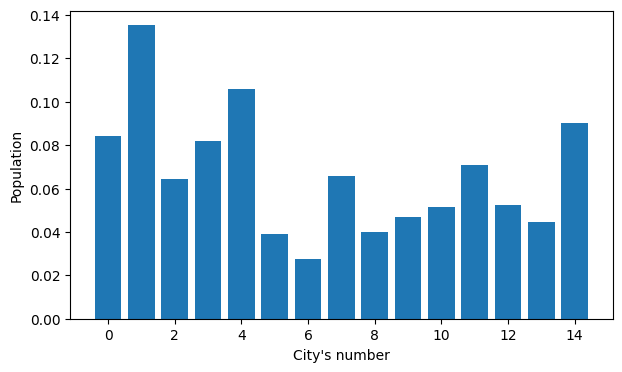

In [9]:
plt.figure(figsize=(7, 4))
plt.hist(walk, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

Полученная гистограмма почти не отличается от гистограммы, задающей распределения числа жителей по городам. Таким образом, массив ```walk``` можно рассматривать как выборку из данного распределения, а предложенный процесс обхода городов - как генератор случайных чисел из этого распределения.

Несколько замечаний:
* Полезно отбросить начальный кусок массива ```walk```, пока последовательность не вышла на стационарный режим
* В нашей реализации соседные элементы массива ```walk``` сильно скоррелированы (по определению, они отличаются не более чем на 1). Поэтому полезно проредить ряд.

Общая идея MCMC:
* построить эргодическую цепь Маркова, для которой стационарное распределение - это в точности наше заданное распределение

* инициировать блуждание по цепи Маркова из некоторого начального состояния и дождаться, когда распределение сойдется в стационарному. С этого момента состояния цепи Маркова можно считать выборкой из желаемого распределения.

Одним из способов реализации этой идеи является алгоритм Метрополиса — Гастингса  (Metropolis — Hastings):
* пусть $\pi$ -- распределение на множестве $R^d$, из которого хотим научиться моделировать случайные величины
* выберем произвольное $X_0$ из $R^d$ в качестве первого элемента последовательности
* далее для каждого $i$:
  * для текущего $X_i$ смоделируем значение $Z_{i+1}$ из $d$-мерного гауссовского распределения $N(X_i, \sigma^2 I)$
  * смоделируем случайную величину $\alpha$ из распределения Бернулли с вероятностью успеха
$$
p = \min ( 1, \frac{\pi(X_i)}{\pi(Z_{i+1})} )
$$
  * если $\alpha$ = 1, то $X_{i+1} = Z_{i+1}$, иначе $X_{i+1} = X_{i}$.

Утверждается, что распределение $X_i$ с ростом $i$ сходится к $\pi$.

Несколько замечаний:
1. Выбор именно гауссовского распределения не существенен. Подойдет любое симметричное распределение, являющееся переходной плотностью цепи Маркова с состояниями на всем $R^d$.
2. Поскольку в формуле участвует только отношение плотностей, достаточно знать плотность с точностью до множителя-константы.

Реализуем алгоритм Метрополиса — Гастингса. Функция `metroplis` принимает на вход
* начальное состояние цепи Маркова (`start`)
* функцию, вычисляющую значение плотности в произвольной точке (функция `value`)
* функцию, предлагающую выбор нового состояния (функция `proposal`)
* количество итераций (`niter`)

In [10]:
def metroplis(start, value, proposal, niter, nburn=0, **kwargs):
    '''Generic Metropolis scheme.

    Parameters
    ---
    start : misc
        Initial guess.
    value : callable
        Function to calculate density at given point.
    proposal : callable
        Function to get suggestion on a new point based on a current one.
    niter : int
        Number of iterations.
    nburn : int
        Number of initial samples to be skipped.
    kwargs : dict
        Keywords to be passed in value and proposal.

    Return
    ---
    post : list
        List of samples obtained.
    '''
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current, **kwargs)
        p = value(proposed, **kwargs) / value(current, **kwargs)
        if np.random.rand() < p:
            current = proposed
        post.append(current)
    return post[nburn:]

В приложение к предыдущей задаче вот как определяются `value` и `proposal` и как выглядит гистограмма, полученная по смоделированной выборке:

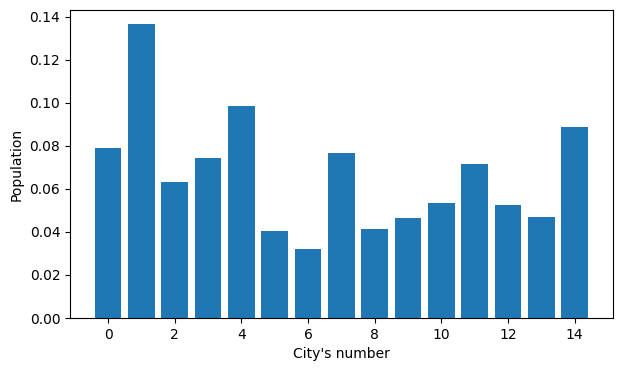

In [11]:
value = lambda x: cities[x]
proposal = lambda x: (x + np.random.choice([-1, 1])) % len(cities)
post = metroplis(1, value, proposal, 10000)

plt.figure(figsize=(7, 4))
plt.hist(post, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

Далее рассмотрим  применение алгоритма Метрополиса — Гастингса для генерации выборки из смеси двух гауссиан (конечно, эту задачу можно решить и другими методами). Плотность смеси задается в виде
p(x) = 0.3N(-4, 2) + 0.7N(3, 6), где N(a, b) - плотность нормального распределения со средним a и дисперсией b. Для наглядности, ниже приведен график плотности смеси.

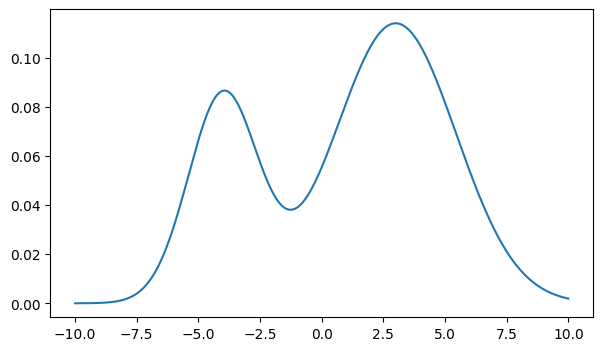

In [12]:
from scipy.stats import norm

x = np.linspace(-10, 10, 1000)

def mixture(x, **kwargs):
  _ = kwargs
  return 0.3*norm(-4, np.sqrt(2)).pdf(x) + 0.7*norm(3, np.sqrt(6)).pdf(x)

plt.figure(figsize=(7, 4))
plt.plot(x, mixture(x))
plt.show()

Задаем функцию, которая моделирует шаг величиной из нормального распределения с некоторой дисперсией $\sigma^2$:

In [13]:
def proposal(current, sigma, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    sigma = np.asarray(sigma)
    return current + sigma * np.random.randn(*current.shape)

Моделируем последовательность длины 10000 по алгоритму Метрополиса — Гастингса:

In [14]:
post = metroplis(3, mixture, proposal, 10000, sigma=1)

Сравниваем искомую плотность и плотность по полученной выборке:

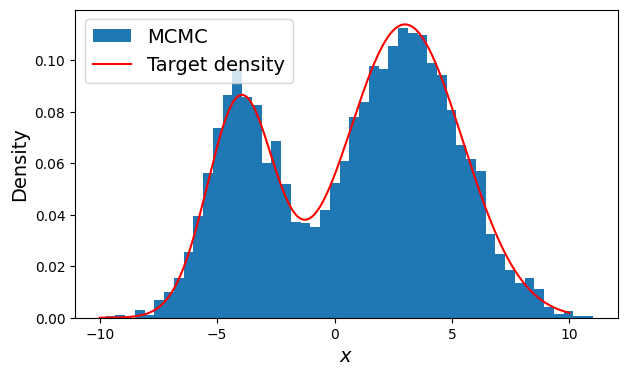

In [15]:
plt.figure(figsize=(7, 4))
plt.hist(post[1000:], bins=50, density=True, label='MCMC')
plt.plot(x, mixture(x), label='Target density', c='r')
plt.legend(fontsize=14)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

Мы выбрали $\sigma=1$. Что будет если этот параметр шага изменить? Ниже на каринке траектория процесса $X_i$ для разных $\sigma$. Видно, что шаги с $\sigma=0.1$ слишком маленькие, процесс долго топчется на месте. Для $\sigma=1$ процесс время от времени прыгает их одной моды распределения в другую и это хорошо. Попробуйте предположить и проверить, что будет, если увеличить  $\sigma$.

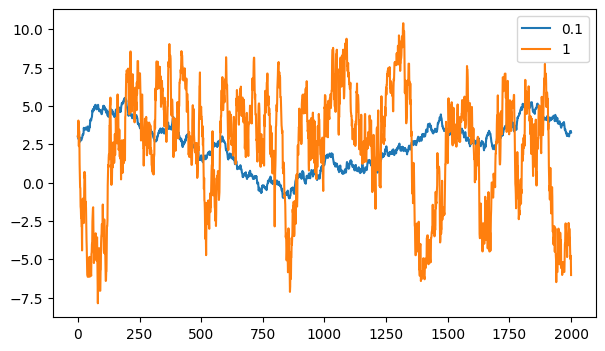

In [16]:
plt.figure(figsize=(7, 4))
for sigma in [0.1, 1]:
    post = metroplis(3, mixture, proposal, 2000, sigma=sigma)
    plt.plot(post, label=sigma)
plt.legend()
plt.show()

Дальше пример того, как ведет себя процесс, выходящих из разных стартовых точек. Видно, что роль стартовой точки быстро теряется (процесс ее "забывает") и это хорошо:

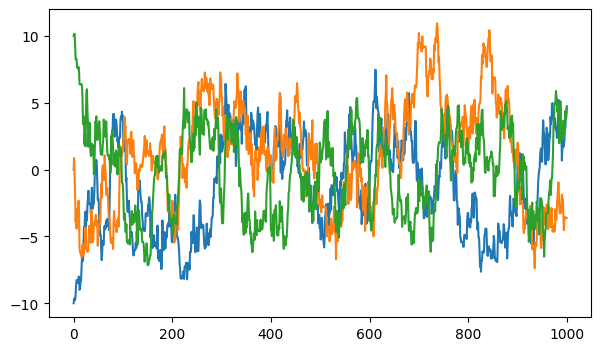

In [17]:
plt.figure(figsize=(7, 4))
for start in [-10, 0, 10]:
    post = metroplis(start, mixture, proposal, 1000, sigma=1)
    plt.plot(post)
plt.show()

Несколько важных замечаний.
1. Как понять, что последовательность вышла на стационарный режим? Для этого применяют статистические тесты на стационарность. Например, тест на однородность выборок в двух непересекающихся кусках последовательности.
2. Как понять, с каким шагом прореживать выборку, чтобы элементы стали независимыми? Построить автокорреляционную функцию -- график корреляции $corr(X_i, X_{i+k}$) для разных $k$ и найти, при каком $k$ корреляция становится маленькой.

**Задание 5**. Методом Метрополиса — Гастингса постройте выборку из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей B = [[40, -26], [-26, 25]]. Сравните плоность по выборке (двумерную гистограмму) и теоретическую плотность.

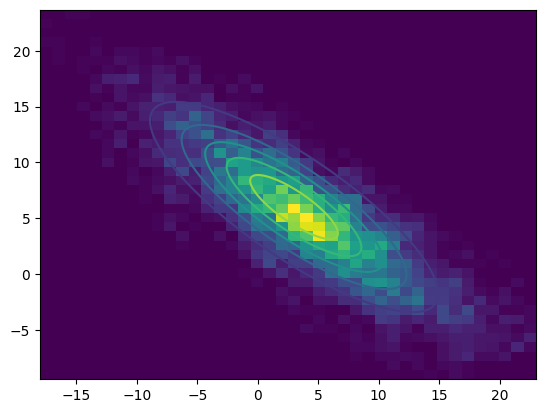

In [40]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
#дано:
a = np.array([3,6])
B = np.array([[40, -26], [-26, 25]])
#задаем отрезок [-Edge, Edge], и создаем сетку из точек
Edge = 20
x,y = np.mgrid[-Edge:Edge:Edge*0.001, -Edge:Edge:Edge*0.001]
#задаем матрицу точек(совмещаем x и y)
Matrix_of_dots = np.dstack((x,y))
theoretical_density = multivariate_normal(a, B)
pdf = theoretical_density.pdf(Matrix_of_dots)
#рисуем теор плотность
plt.contour(x, y, pdf)
#функцию metrpolis берем ту же, однако меняем value на двумерный гауссовский случай
def my_value(vector_2d, **kwargs):
  _ = kwargs
  return theoretical_density.pdf(vector_2d)
#proposal зададим так:
def my_proposal(current, sigma, **kwargs):
  _ = kwargs
  current = np.asarray(current)
  sigma = np.asarray(sigma)
  return current + sigma * np.random.randn(*current.shape)
my_sigma = 1
result = metroplis(a, my_value ,my_proposal , 10000, sigma = my_sigma)
result_x = np.zeros(10001)
result_y = np.zeros(10001)
for i in range (10001):
  result_x[i] = result[i][0]
  result_y[i] = result[i][1]
plt.hist2d(result_x,result_y, bins = 40)
plt.show()

## Gibbs sampling

Рассмотрим еще один алгоритм моделироваиня выборки методом МСМС -- cэмплирование по Гиббсу.

Алгоритм применим в тех случаях, когда вам нужно смоделировать величину и некоторой совместной плотности
$p(x_1, x_2, ..., x_d)$ и вы умеете моделировать случайные величины из всех одномерных условных плотностей
$p(x_i|x_1, x_2, ..., x_{i-1}, x_{i+1}, ..., x_d)$.

Алгоритм:
* берем произвольную начальную точку $(x_1^{(0)}, x_2^{(0)}, ..., x_d^{(0)})$
* для каждого $i=1, 2, ...$:
  * для каждого $j=1, 2, ...,d$:
    * сэмплируем $x_j^{(i)} \sim p(x_j|x_1^{(i-1)}, x_2^{(i-1)},..., x_{j-1}^{(i-1)}, x_{j+1}^{(i)}, ...,x_{d}^{(i)})$
  * добавляем точку $(x_1^{(i)}, x_2^{(i)}, ..., x_d^{(i)})$ в выборку

Утверждается, что получаемая выборка образует эргодическую цепь Маркова со стационарной плотностью $p(x_1, x_2, ..., x_d)$.

Для алгоритма cэмплирования по Гиббсу также возникают вопросы о том, когда последовательность выходит на стационарный режим и с какой частотой прореживать выборку, чтобы оставлять независимые элементы. Для решения можно применять те же идеи, что обсуждались ранее для метода Метрополиса — Гастингса.

**Задание 6.** Решите задачу 5 методом cэмплирования по Гиббсу.

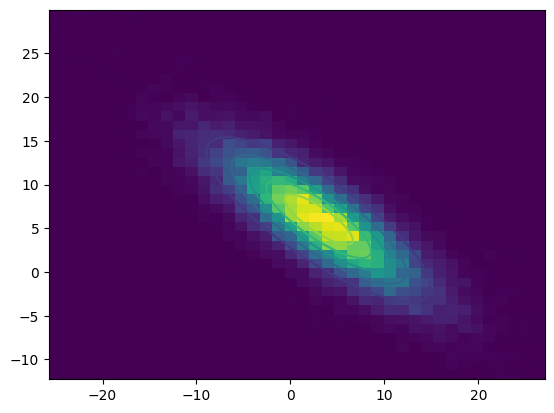

In [86]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
#дано:
a = np.array([3,6])
B = np.array([[40, -26], [-26, 25]])
#задаем отрезок [-Edge, Edge], и создаем сетку из точек
Edge = 20
x,y = np.mgrid[-Edge:Edge:Edge*0.001, -Edge:Edge:Edge*0.001]
#задаем матрицу точек(совмещаем x и y)
Matrix_of_dots = np.dstack((x,y))
theoretical_density = multivariate_normal(a, B)
pdf = theoretical_density.pdf(Matrix_of_dots)
#рисуем теор плотность
plt.contour(x, y, pdf)
#гибс сэмплинг:
#пользуемся формулой из дз№6:
N = 20000
result_x = np.zeros(N+1)
result_y = np.zeros(N+1)
#стартовая точка
start_point = ([3.0, 6.0])
result_x[0] = start_point[0]
result_y[0] = start_point[1]
for i in range(1, N + 1):
    new_mean_x = a[0] + (B[0][1]/B[1][1])*(result_y[i-1]-a[1])
    new_std_x  = np.sqrt(B[0][0] - (B[0][1]*B[1][0])/B[1][1])
    result_x[i] = np.random.normal(new_mean_x, new_std_x)
    new_mean_y = a[1] + (B[0][1]/B[0][0])*(result_x[i]-a[0])
    new_std_y  = np.sqrt(B[1][1] - B[0][1]*B[1][0]/B[0][0])
    result_y[i] = np.random.normal(new_mean_y, new_std_y)
plt.hist2d(result_x,result_y, bins = 40)
plt.show()

**Задание 7 (со звездочкой)**

Рассмотрим граф $G=(V,E)$, вершинам которого случайным образом приписаны значения 0 и 1 так, что смежные вершины не могут одновременно иметь значение 1. Пример расстановки значений по вершинам графа показан на картинке ниже (черные вершины имеют значение 1, белые - 0):

<!-- ![img](http://www.mathematik.uni-ulm.de/stochastik/lehre/ss06/markov/skript_engl/bild4.jpg) -->

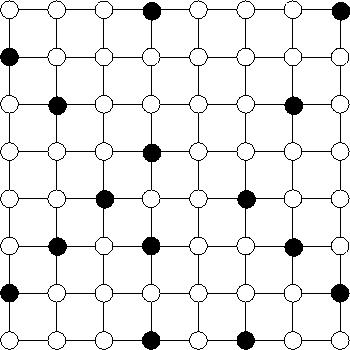

Как оценить, сколько в среднем закрашенных вершин будет иметь такой граф?

Сформулируем задачу в математических терминах.

Пусть $\xi \in \{0,1\}^{V}$ обозначает конфигурацию графа (расстановку 0 и 1 по вершинам). Назовем конфигурацию допустимой, если вершины, соединенные ребрами, не имеют одновременно значения 1. Пусть $Z_G$ - общее количество допустимых конфигураций. Зададим  распределение на множестве всех конфигураций:
$$\begin{equation*}
\mu(\xi) =
 \begin{cases}
   \frac{1}{Z_G}, &\text{$\xi$ - допустимая конфигурация}\\
   0, &\text{иначе.}
 \end{cases}
\end{equation*}$$
Обозначим $n(\xi)$ - число закрашенных вершин в конфигурации $\xi$. Тогда
$$
{\rm E} n(\xi) = \sum\limits_{x \in \{0,1\}^V} n(x) \mu(x) = \frac{1}{Z_G} \sum\limits_{x \in \{0,1\}^V} n(x) {\rm I}_{\{x - \text{допустимая} \}}
$$

Явно перебирать все $x \in \{0,1\}^{V}$ не представляется возможным. Мы могли бы попробовать оценить ${\rm E} n(\xi)$, используя закон больших чилел:
$$
{\rm E} n(\xi) \approx \frac{1}{N} \sum\limits_{i=1}^{N} n(\xi), \text{где $\xi \sim \mu$}
$$
Но есть проблема: как смоделировать случайную величину из распределения $\mu$?

В этом поможет метод MCMC.

Задание
* Оценить  En(ξ)  с помощью МСМС для графа 10х10
* Построить график распределеиня  n(ξ)
* Изобразить один из случайных графов, взятых из стационарного распределения.

Идея решения
1. выбираем случайную вершину
2. если в вершине можно заменить цвет - заменяем с вероятностью 0.5
3. добавляем граф в выборку
4. переходим на шаг 1
Для проверки, на графах размера 2х2 точный ответ = 8/7 ~ 1.1428...

## Литература

*  http://probability.ca/jeff/ftpdir/johannes.pdf
* https://www.math.arizona.edu/~tgk/mc/book_chap8.pdf

## MCMC demo
* https://chi-feng.github.io/mcmc-demo/
